In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tira.rest_api_client import Client
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns

In [2]:
tira = Client()
   
    # loading train data
text_train = tira.pd.inputs(
        "nlpbuw-fsu-sose-24", "language-identification-train-20240429-training"
)
targets_train = tira.pd.truths(
        "nlpbuw-fsu-sose-24", "language-identification-train-20240429-training"
)
 # loading validation data (automatically replaced by test data when run on tira)
text_validation = tira.pd.inputs(
        "nlpbuw-fsu-sose-24", "language-identification-validation-20240429-training"
)
targets_validation = tira.pd.truths(
        "nlpbuw-fsu-sose-24", "language-identification-validation-20240429-training"
)

### Separate Latin from Non-Latin

In [3]:
latin = ['af', 'az', 'cs', 'da', 'de', 'en', 'es', 'fi', 'fr', 'hr', 'it', 'nl', 'no', 'pl'] # '0041-024F'
latin_label = np.isin(targets_train['lang'], latin)
df = pd.DataFrame(latin_label, columns=["latin"])
targets_train_latin_labeled = pd.concat([targets_train, df] , axis =1)
#print(targets_train_latin_labeled)
targets_train_latin_only = targets_train_latin_labeled.drop(targets_train_latin_labeled[targets_train_latin_labeled.latin == False].index)
print(targets_train_latin_only)

text_train_latin_labeled = pd.concat([text_train, df] , axis =1)
text_train_latin_only = text_train_latin_labeled.drop(text_train_latin_labeled[text_train_latin_labeled.latin == False].index)

# same for validation dataset
latin_label_val = np.isin(targets_validation['lang'], latin)
df2 = pd.DataFrame(latin_label_val, columns=["latin"])
targets_val_latin_labeled = pd.concat([targets_validation, df2] , axis =1)
targets_val_latin_only = targets_val_latin_labeled.drop(targets_val_latin_labeled[targets_val_latin_labeled.latin == False].index)
text_val_latin_labeled = pd.concat([text_validation, df2] , axis =1)
text_val_latin_only = text_val_latin_labeled.drop(text_val_latin_labeled[text_val_latin_labeled.latin == False].index)
print(text_val_latin_only)

            id lang  latin
0            1   de   True
2            3   da   True
3            4   de   True
5            6   az   True
9           10   fi   True
...        ...  ...    ...
319994  399993   es   True
319995  399994   cs   True
319996  399995   hr   True
319997  399996   az   True
319998  399998   it   True

[224000 rows x 3 columns]
           id                                               text  latin
0          14  Suzanna, la rivale de Candy, est morte de mala...   True
1          26  W wyniku agresji radzieckiej na Polskę 17 wrze...   True
3          52  Azilal (berbisk : ⴰⵣⵉⵍⴰⵍ) er en provins i den ...   True
4          63  Nalazi se na 46° 7' sjeverne zemljopisne širin...   True
5          65  Na standardnim registarskim pločicama sva slov...   True
...       ...                                                ...    ...
39993  399936  Mientras estaba exiliado en Rabat (Marruecos) ...   True
39996  399960  Državni rezervat prirode Shennongjia (神农架国家自然保...   True
3

### Convert languages to IDs

In [4]:
#targets_train_encoded = LabelEncoder().fit_transform(targets_train_latin_only["lang"])
#targets_val_encoded = LabelEncoder().fit_transform(targets_val_latin_only["lang"])
#print(targets_train_encoded[:10])
#print(len(np.unique(targets_train_encoded))) #14 latin languages in dataset

### Remove Punctation and convert to lower case.

In [4]:
remove_punctuation = str.maketrans('', '', r"-()\"#/@;:<>{}-=~|.?,")

def PunctFreeLower(texts):
    cleaned = []
    for text in texts:
        # punctation gets replaced by space and 
        # all letters are converted to lower case
        cleaned.append((text.translate(remove_punctuation)).lower())
    return cleaned

In [5]:
text_train_cleaned = PunctFreeLower(text_train_latin_only["text"])
text_val_cleaned = PunctFreeLower(text_val_latin_only["text"])
print(text_train_cleaned[:4])

['der flughafen berlin brandenburg verfügt über zwei parallele start und landebahnen 07r25l und 07l25r der abstand zwischen den start und landebahnen beträgt 1900 m der versatz 1250 m damit können beide start und landebahnen ohne beeinträchtigungen durch wirbelschleppen unabhängig voneinander betrieben werden alle rollwege vorfelder und start und landebahnen belegen eine fläche von annähernd 17 km2', 'i øvrigt er kendetegnene for en magnetisk svag periode også at der opstår 2 magnetiske nord og sydpoler og noget tyder ligefrem på at der kan opstå 4 af hver slags man kan sige at jordens magnetfelt gennemgår perioder hvor det nærmest helt opløsesudviskes årsagen til dette er også ukendt der arbejdes i disse år heftigt på at forstå de mange uforståede sammenhænge herunder også årsagen til den store magnetosfære anomali den sydatlantiske anomali og årsagen til de mange skorpe anomalier fx en af jordens største der befinder sig i det centrale afrika ', 'sowohl über den historischen simon al

In [22]:
vec = CountVectorizer(max_features=8000)
text_train_vec = vec.fit_transform(text_train_cleaned)
text_val_vec = vec.fit_transform(text_val_cleaned)

#vec2 = CountVectorizer(analyzer='char', ngram_range=(2, 3), max_features=15000)
#text_train_vec2 = vec2.fit_transform(text_train_cleaned)
#text_val_vec2 = vec2.fit_transform(text_val_cleaned)

print(text_train_vec[:4])


  (0, 1608)	3
  (0, 912)	1
  (0, 7895)	1
  (0, 7814)	1
  (0, 6418)	4
  (0, 7095)	6
  (0, 7817)	1
  (0, 1600)	1
  (0, 121)	1
  (0, 1511)	1
  (0, 3711)	1
  (0, 875)	1
  (0, 4850)	1
  (0, 1824)	1
  (0, 7531)	1
  (0, 506)	1
  (0, 1959)	1
  (0, 7406)	1
  (0, 28)	1
  (0, 3559)	1
  (1, 1608)	4
  (1, 1600)	2
  (1, 2082)	2
  (1, 2346)	1
  (1, 2022)	2
  :	:
  (2, 1963)	1
  (2, 3116)	1
  (2, 1620)	1
  (2, 6055)	1
  (2, 7801)	1
  (2, 4281)	1
  (2, 7130)	1
  (2, 6452)	1
  (3, 780)	1
  (3, 7468)	8
  (3, 7686)	1
  (3, 758)	1
  (3, 7942)	1
  (3, 774)	2
  (3, 7207)	1
  (3, 5643)	1
  (3, 3522)	2
  (3, 3234)	1
  (3, 1901)	1
  (3, 7902)	1
  (3, 3027)	1
  (3, 4775)	1
  (3, 7671)	1
  (3, 3026)	1
  (3, 5637)	1


In [16]:
print(text_train_vec.shape)
print(vec.get_feature_names_out())

(224000, 15000)
['00' '000' '01' ... 'əvvəllərində' 'əvəz' 'ʼn']


### Fit Bernoulli Naive Bayes

In [23]:
model = BernoulliNB()
#model = MultinomialNB()
model.fit(text_train_vec, targets_train_latin_only["lang"])

BernoulliNB()

Accuracy is 43.5%
F1-score is 43.412344528064324%


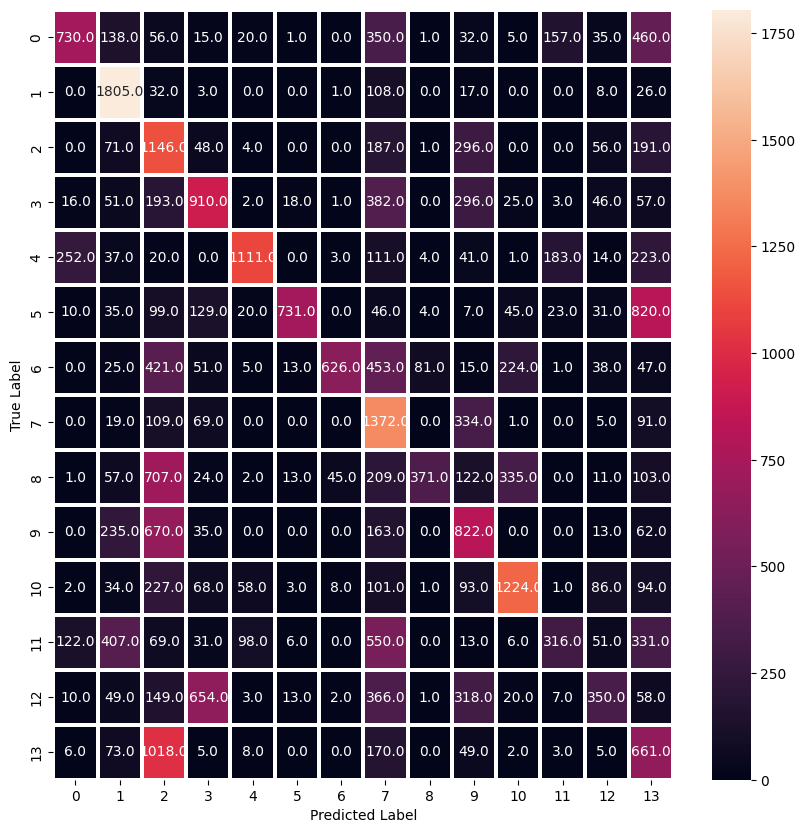

In [24]:
def eval(model, texts, targets):
    y_pred = model.predict(texts)
    conf_matrix = confusion_matrix(y_pred=y_pred,y_true=targets)
    acc = round(accuracy_score(y_pred=y_pred,y_true=targets),3) * 100
    f1 = f1_score(y_pred=y_pred, y_true=targets, average="weighted")*100
    
    print(f"Accuracy is {acc}%")
    print(f"F1-score is {f1}%")
    plt.subplots(figsize=(10,10))
    sns.heatmap(conf_matrix,annot=True,fmt=".1f",linewidths=1.5)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

eval(model, text_val_vec, targets_val_latin_only["lang"])